In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torchts.nn.model import TimeSeriesModel

# Generate dataset

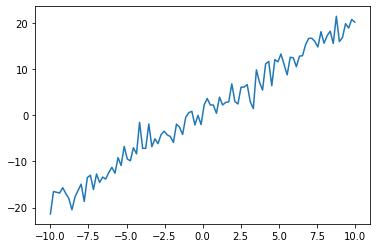

In [2]:
# generate linear time series data with some noise
x = np.linspace(-10,10,100).reshape(-1,1).astype(np.float32)
y = 2*x+1 + np.random.normal(0, 2, x.shape).reshape(-1,1).astype(np.float32)
plt.plot(x.flatten(), y.flatten())
plt.show()

# Build a LSTM model

In [3]:
class LSTM(TimeSeriesModel):
    def __init__(self, input_size, output_size, optimizer, hidden_size=8, batch_size=10, **kwargs):
        super(LSTM, self).__init__(optimizer, **kwargs)
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.lstm = torch.nn.LSTMCell(input_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def init_hidden(self):
        # initialize the hidden state and the cell state to zeros
        return (torch.zeros(self.batch_size, self.hidden_size),
                torch.zeros(self.batch_size, self.hidden_size))

    def forward(self, x, y=None, batches_seen=None):
        hc = self.init_hidden()
        
        hidden, _ = self.lstm(x, hc)
        out = self.linear(hidden)
        return out

# Train LSTM model and perform inference

In [4]:
inputDim = 1       
outputDim = 1
optimizer_args = {"lr": 0.01}
batch_size = 10

criterion = torch.nn.MSELoss() 
model = LSTM(inputDim, outputDim, torch.optim.Adam, optimizer_args=optimizer_args)

In [5]:
# train model
model.fit(
    torch.from_numpy(x),
    torch.from_numpy(y),
    max_epochs=120,
    batch_size=batch_size,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")

  | Name   | Type     | Params
------------------------------------
0 | lstm   | LSTMCell | 352   
1 | linear | Linear   | 9     
------------------------------------
361       Trainable params
0         Non-trainable params
361       Total params
0.001     Total estimated model params size (MB)


Epoch 2:  70%|███████   | 7/10 [00:00<00:00, 265.16it/s, loss=125, v_num=73, train_loss_step=120.0, train_loss_epoch=134.0]

/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 119: 100%|██████████| 10/10 [00:00<00:00, 149.65it/s, loss=3.38, v_num=73, train_loss_step=6.810, train_loss_epoch=3.400]


In [6]:
# inference
y_pred = []
for x_batch in torch.split(torch.from_numpy(x), batch_size):
    y_pred.append(model.predict(x_batch).detach().numpy())
y_pred = np.concatenate(y_pred)

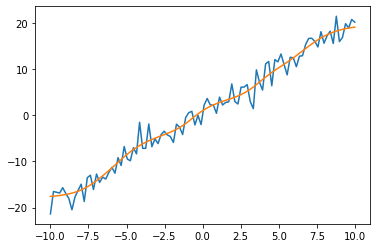

In [7]:
plt.plot(x.flatten(), y.flatten())
plt.plot(x.flatten(), y_pred.flatten())
plt.show()

# Enable uncertainty quantification in LSTM model

In [8]:
import torch

from torchts.nn.loss import quantile_loss

In [9]:
inputDim = 1       
outputDim = 3 # 3 quantiles [0.025, 0.5, 0.975]
optimizer_args = {"lr": 0.01}
batch_size = 10

criterion = torch.nn.MSELoss() 
model_uq = LSTM(inputDim, outputDim, torch.optim.Adam, criterion=quantile_loss, optimizer_args=optimizer_args)

In [10]:
# train model
model_uq.fit(
    torch.from_numpy(x),
    torch.from_numpy(y),
    max_epochs=200,
    batch_size=batch_size,
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:101: UserWarning: you defined a validation_step but have no val_dataloader. Skipping val loop
  rank_zero_warn(f"you defined a {step_name} but have no {loader_name}. Skipping {stage} loop")

  | Name   | Type     | Params
------------------------------------
0 | lstm   | LSTMCell | 352   
1 | linear | Linear   | 27    
------------------------------------
379       Trainable params
0         Non-trainable params
379       Total params
0.002     Total estimated model params size (MB)


Epoch 1:  20%|██        | 2/10 [00:00<00:00, 89.05it/s, loss=15.4, v_num=74, train_loss_step=19.10, train_loss_epoch=15.00] 

/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/kailing/Documents/GitHub/DSC/dsc_180a/torchTS/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:322: UserWarning: The number of training samples (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 199: 100%|██████████| 10/10 [00:00<00:00, 155.04it/s, loss=6.05, v_num=74, train_loss_step=6.430, train_loss_epoch=6.050]


In [11]:
# inference
y_pred = []
for x_batch in torch.split(torch.from_numpy(x), batch_size):
    y_pred.append(model_uq.predict(x_batch).detach().numpy())
y_pred = np.concatenate(y_pred)

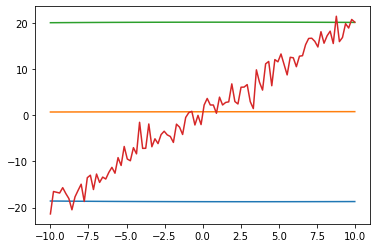

In [12]:
plt.plot(x.flatten(), y_pred[:, 0])
plt.plot(x.flatten(), y_pred[:, 1])
plt.plot(x.flatten(), y_pred[:, 2])
plt.plot(x.flatten(), y.flatten())